In [1]:
import numpy as np
import pandas as pd
import netCDF4 as nc4
from netCDF4 import Dataset
import xarray as xr
from datetime import datetime, timedelta, timezone
import os
import math
import ruptures as rpt
import multiprocessing
from pylab import rcParams
import glob
import gsw
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from matplotlib import patches
from matplotlib.colors import Normalize

import scipy
from scipy import interpolate
from scipy import signal
from scipy.interpolate import griddata
from scipy import stats

import cartopy.crs as ccrs
import cartopy.util as cutil
from cartopy.mpl.ticker import LatitudeFormatter,LongitudeFormatter

dirhome = os.environ['HOME']
plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
# This needs to be called separately from the first line for some reason (otherwise the above xr.open_dataset code gives an error, dunno why!)
import pvlib
from pvlib.location import Location

In [3]:
from urllib import request
import re
dirhome = os.environ['HOME']
from scipy.stats import pearsonr,spearmanr
#Uncomment the following lines related to dask if kernel gets killed.
from dask.distributed import Client
client = Client()
client

#list of tab colors
import matplotlib.colors as mcolors
tabcol = list(mcolors.TABLEAU_COLORS)
abc = 'abcdefghijklmopqrstuvwxyz'
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#from chatgpt
def extract_before_last_slash(input_string):
    last_slash_index = input_string.rfind('/')
    if last_slash_index != -1:
        return input_string[:last_slash_index]
    else:
        return input_string

In [ ]:
try:
    data = pd.read_csv('https://data-argo.ifremer.fr/argo_synthetic-profile_index.txt',skiprows=8)
    print('Accessing the IFREMER server')
except:
    data = pd.read_csv('https://usgodae.org/ftp/outgoing/argo/argo_synthetic-profile_index.txt',skiprows=8)
    print('The IFREMER server is currently not accessible. Accessing the USGODAE server instead')

In [5]:
lon0 = 120
lon1 = 150
lat0 = 20
lat1 = 50
date0 = 20240101
date1 = 20241231

In [27]:
#extract the dataset based on lon, lat, and variable (chl). Date has a weird format so extract first then postprocess dates
datasub = data[(data['longitude'] >= lon0) & (data['longitude'] <= lon1) &
               (data['latitude'] >= lat0) & (data['latitude'] <= lat1) &
               (data['date'] >= 0) & 
               (data['parameters'].str.contains('NITRATE')) & 
               (data['parameter_data_mode'].str[-1].isin(['A', 'D']))]

#add the new variable called 'hour' referring to the hour of sampling
#extract the two digits after yyyymmdd corresponding to hh of hhmmss
hourstr = [str(num) for num in datasub['date']]
hourstr = [num[8:8+2] for num in hourstr]
hourint = [int(num) for num in hourstr]
datasub['hour'] = hourint

#add the new variable called 'time' referring to the hour of sampling
#extract the 6 digits after yyyymmdd corresponding to hhmmss
#NOTE: time is provided as string to avoid inconsistent digits for hours
timestr = [str(num) for num in datasub['date']]
timestr = [num[8:8+6] for num in timestr]
datasub['time'] = timestr

#modify the date format to be yyyymmdd
datestr = [str(num) for num in datasub['date']]
datestr = [num[0:8] for num in datestr]
dateint = [int(num) for num in datestr]
datasub['date'] = dateint
#create a new column called floatid for lagrangian time series plot
tmpfloatid = []
for i in range(np.size(datasub['date'])):
    tmpfloatid.append(datasub['file'].values[i].split('/')[1])
datasub['floatid'] = tmpfloatid
#refine the dataset based on the selected period
datasub = datasub[(datasub['date'].values >= date0) & (datasub['date'].values <= date1)]

/var/folders/1j/tpsfn7p15fn9p_jppny0yq8w0000gp/T/ipykernel_76965/3328182890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datasub['hour'] = hourint
/var/folders/1j/tpsfn7p15fn9p_jppny0yq8w0000gp/T/ipykernel_76965/3328182890.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datasub['time'] = timestr
/var/folders/1j/tpsfn7p15fn9p_jppny0yq8w0000gp/T/ipykernel_76965/3328182890.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [28]:
datasub['file'].values

array(['aoml/5906510/profiles/SD5906510_025.nc',
       'aoml/5906510/profiles/SD5906510_026.nc',
       'aoml/5906510/profiles/SD5906510_027.nc',
       'aoml/5906510/profiles/SD5906510_028.nc',
       'aoml/5906510/profiles/SD5906510_029.nc',
       'aoml/5906510/profiles/SD5906510_030.nc',
       'aoml/5906510/profiles/SD5906510_031.nc',
       'aoml/5906510/profiles/SD5906510_032.nc',
       'aoml/5906510/profiles/SD5906510_033.nc',
       'aoml/5906510/profiles/SD5906510_034.nc',
       'aoml/5906510/profiles/SD5906510_035.nc',
       'aoml/5906510/profiles/SD5906510_036.nc',
       'aoml/5906510/profiles/SD5906510_037.nc',
       'aoml/5906510/profiles/SD5906510_038.nc',
       'aoml/5906510/profiles/SD5906510_039.nc',
       'aoml/5906510/profiles/SD5906510_040.nc',
       'aoml/5906510/profiles/SD5906510_041.nc',
       'aoml/5906510/profiles/SD5906510_042.nc',
       'aoml/5906510/profiles/SD5906510_043.nc',
       'aoml/5906510/profiles/SD5906510_044.nc',
       'aoml/5906510

In [ ]:
for i in range(datasub.shape[0]):
    dir = 'ftp.ifremer.fr/ifremer/argo/dac/'+datasub['file'].values[i]
    !curl -L -O {dir}

## The following is the correction of data.

#### Choose the float you use
##### For example SD5906510,SR7902116...

#### Read datas from all profiles from the float you choosed

In [8]:
fnum = 'SD5906519'
var1 = "NITRATE"
var2 = "NITRATE_ADJUSTED"

In [9]:
file_pattern = f"{fnum}_*.nc"

# ファイルパターンに一致するすべてのファイルを取得
file_list = sorted(glob.glob(file_pattern))  # ソートして番号順に処理
if not file_list:
    raise FileNotFoundError(f"No files found matching pattern: {file_pattern}")
    
# データを格納するリスト
concat_plist = []
concat_slist = []
#concat_var1_list = []
concat_var2_list = []
qc_list = []
lon_list = []
lat_list = []
time_list = []
min_depth_size = None
base_date = datetime(1950, 1, 1)

# ファイルを順番に読み込む
for file_name in file_list:        
    # netCDF ファイルを開く
    with Dataset(file_name, mode='r') as nc:
        if "NITRATE_ADJUSTED" not in nc.variables:
            print(f"Variable 'NITRATE_ADJUSTED' not found in {file_name}")
            continue

        # QC フラグの取得とチェック
        if "NITRATE_ADJUSTED_QC" in nc.variables:
            qc_flags = nc.variables["NITRATE_ADJUSTED_QC"][:]
            qc_flags_str = np.where(qc_flags.mask, ' ', qc_flags.astype(str))  # マスク部分は空白
            valid_qc_mask = np.isin(qc_flags_str, ['1', '2', '8'])  # QCが1,2,5のもの
        else:
            print(f"NITRATE_ADJUSTED_QC が {file_name} に存在しません。")
            continue

        # QC フラグの取得とチェック
        if "PSAL_QC" in nc.variables:
            sqc_flags = nc.variables["PSAL_QC"][:]
            sqc_flags_str = np.where(sqc_flags.mask, ' ', sqc_flags.astype(str))  # マスク部分は空白
            valid_sqc_mask = np.isin(sqc_flags_str, ['1', '2'])  # QCが1,2のもの
        else:
            print(f"PSAL_QC が {file_name} に存在しません。")
            continue
        
        # 指定された変数のデータを取得
        # 時間ステップ
        juld = nc.variables["JULD"][:][0]
        time = base_date + timedelta(days=juld)

        # 緯度・経度データ
        lat = nc.variables["LATITUDE"][:][0]
        lon = nc.variables["LONGITUDE"][:][0]

        # 変数
        pdata = nc.variables["PRES"][:, :]
        sdata = nc.variables["PSAL"][:, :]

        #var1_data = nc.variables["NITRATE"][:, :]
        var2_data = nc.variables["NITRATE_ADJUSTED"][:, :]
        lon_data = nc.variables["LONGITUDE"][:]
        lat_data = nc.variables["LATITUDE"][:]
        # mask
        pdata = np.where(pdata >= 99999.0, np.nan, pdata)
        #var1_data = np.where(var1_data >= 99999.0, np.nan, var1_data)
        var2_data = np.where(var2_data >= 99999.0, np.nan, var2_data)

        # QC フラグでフィルタリング
        var2_data[~valid_qc_mask] = np.nan
        sdata[~valid_sqc_mask] = np.nan


        # 深度方向のサイズを取得
        depth_size = pdata.shape[1]        
        # 最初のファイルの場合、最小深度を初期化
        if min_depth_size is None:
            min_depth_size = depth_size
        
        # 深度方向のサイズを調整
        if depth_size < min_depth_size:
            # すでに存在するデータを新しい最小深度に切り詰める
            concat_plist = [d[:, :depth_size] for d in concat_plist]
            concat_slist = [d[:, :depth_size] for d in concat_slist]
            #concat_var1_list = [d[:, :depth_size] for d in concat_var1_list]
            concat_var2_list = [d[:, :depth_size] for d in concat_var2_list]
            qc_list = [d[:, :depth_size] for d in qc_list]
            min_depth_size = depth_size
        elif depth_size > min_depth_size:
            # 新しいデータを既存の深度に合わせて切り詰める
            pdata = pdata[:, :min_depth_size]
            sdata = sdata[:, :min_depth_size]
            #var1_data = var1_data[:, :min_depth_size]
            var2_data = var2_data[:, :min_depth_size]
            qc_flags_str = qc_flags_str[:, :min_depth_size]

        # データをリストに追加
        concat_plist.append(pdata)
        concat_slist.append(sdata)
        #concat_var1_list.append(var1_data)
        concat_var2_list.append(var2_data)
        qc_list.append(qc_flags_str)
        lon_list.append(lon_data)
        lat_list.append(lat_data)
        time_list.append(time)

# リストを numpy 配列に結合
concat_parray = np.concatenate(concat_plist, axis=0)
concat_sarray = np.concatenate(concat_slist, axis=0)
lon_array = np.array(lon_list)[:]
lat_array = np.array(lat_list)[:]
#concat_v1array = np.concatenate(concat_var1_list, axis=0)
concat_v2qarray = np.concatenate(concat_var2_list, axis=0)
concat_qcarray = np.concatenate(qc_list, axis=0)

min_depth = int(concat_parray[:, -1].min())
print(f"Max interpolated depth is: {min_depth} dbar")
print(f"Concatenated 'NITRATE_ADJUSTED_QC' data shape: {concat_v2qarray.shape}")

#############################################################################################

depth_l = int(np.fix(concat_parray[:, -1].min()))

depth_lerp = np.arange(0, depth_l, 1)

# 補間後のデータを格納するための配列を作成
#lerp_raw = np.empty((concat_v1array.shape[0], len(depth_lerp)))  # (時間ステップ, 深度範囲)
lerp_adjusted_qc = np.empty((concat_v2qarray.shape[0], len(depth_lerp)))  # (時間ステップ, 深度範囲)

# 各時間ステップで補間処理
for i in range(concat_parray.shape[0]):
    # NaNを除外した有効データを取得
    valid_mask = ~np.isnan(concat_parray[i, :]) & ~np.isnan(concat_v2qarray[i, :])
    valid_depth = concat_parray[i, valid_mask]
    #valid_v1 = concat_v1array[i, valid_mask]
    valid_v2 = concat_v2qarray[i, valid_mask]

    # 線形補間を実行
    v2_ldata = interpolate.interp1d(
        valid_depth, 
        valid_v2, 
        bounds_error=False,  # 範囲外は補間せずにfill_valueを適用
        fill_value=np.nan    # 範囲外のデータはNaNに設定
    )
    lerp_adjusted_qc[i, :] = v2_ldata(depth_lerp)

print(lerp_adjusted_qc.shape)

#print(lerp_raw[0, :50])

Max interpolated depth is: 1399 dbar
Concatenated 'NITRATE_ADJUSTED_QC' data shape: (33, 553)
(33, 1399)


#### Define the reference depth data from the minimum of temporal standalization

In [10]:
# 有効な標準偏差を格納
valid_std = []

# 各深度ごとにチェック
for i in range(500, lerp_adjusted_qc.shape[1]):
    depth_data = lerp_adjusted_qc[:, i]  # 深度 i の時間系列データ
    
    if np.any(np.isnan(depth_data)):  
        valid_std.append((i, np.inf))  # NaN を含む場合は無視（無限大の値をセット）
    else:
        valid_std.append((i, (np.nanstd(depth_data))/np.nanmean(depth_data)))  # NaN なしなら標準偏差を計算

# 最小標準偏差の深度を特定
best_depth = min(valid_std, key=lambda x: x[1])[0]

print(f"基準深度: {best_depth} dbar")

基準深度: 1341 dbar


### Use the reference data from WOA2023 annual mean data

##### download from https://www.ncei.noaa.gov/access/world-ocean-atlas-2023/bin/woa23oxnu.pl

#### select NetCDF4 annual mean data ('woa23_all_n00_01a.nc')

In [12]:
dataset = Dataset('woa23_all_n00_01a.nc','r')
dataset.variables
lon_woa=dataset.variables['lon'][:]
lat_woa=dataset.variables['lat'][:]
dep_woa=dataset.variables['depth'][:]
n_an=dataset.variables['n_an'][:]

### Interploated the reference data. vertical: Akima horizontal: linear

In [13]:
new_lat = np.arange(np.round(np.min(lat_array))-1, np.round(np.max(lat_array))+1, 1 / 10)  # 10分刻みの緯度
new_lon = np.arange(np.round(np.min(lon_array))-1, np.round(np.max(lon_array))+1, 1 / 10)
new_dep = np.arange(0, 5500, 1)

w = int(np.round(np.min(lon_array))-1)
e = int(np.round(np.max(lon_array))+1)
s = int(np.round(np.min(lat_array))-1)
n = int(np.round(np.max(lat_array))+1)

n_data = n_an[0, :, s+90:n+90, w+180:e+180]

interpolated_data = np.full((5500, n-s, e-w), np.nan)  # 全てを NaN で初期化

for i in range(e-w): 
    for j in range(n-s):
        depth_data = n_data[:, j, i]  # 位置(i, j)におけるデータ
        akima_rst = interpolate.Akima1DInterpolator(dep_woa, depth_data)  # Akima補間
        interpolated_data[:, j, i] = akima_rst(new_dep)  # 補間結果を格納
ref_data_akima = interpolated_data
ref_field_akima = interpolated_data[best_depth]

In [14]:
data = ref_data_akima  # もともとのデータ (depth, lat, lon)
lon_points = lon_woa[w + 180:e + 180]
lat_points = lat_woa[s + 90:n + 90]

# 空の配列を作成
interpolated_data = np.empty((5500, len(new_lat), len(new_lon)))

# lon方向の線形補間
lon_interpolated_data = np.empty((5500, len(lat_points), len(new_lon)))

for k in range(0, 5500):
    for j in range(len(lat_points)):
        depth_data = data[k, j, :]  # 深さ k におけるデータ (lat, lon)
        # NaN を除外する
        valid_mask = ~np.isnan(depth_data)
        if valid_mask.sum() > 1:  # 有効データが2点以上ある場合のみ補間
            linear_lon = interpolate.interp1d(
                lon_points[valid_mask], depth_data[valid_mask],
                bounds_error=False, fill_value="extrapolate"
            )
            lon_interpolated_data[k, j, :] = linear_lon(new_lon)  # lon方向に補間
        else:
            lon_interpolated_data[k, j, :] = np.nan  # NaN のまま保持

# lat方向の線形補間
for k in range(0, 5500):
    for i in range(len(new_lon)):
        depth_data = lon_interpolated_data[k, :, i]  # lon方向補間後の lat データ
        # NaN を除外する
        valid_mask = ~np.isnan(depth_data)
        if valid_mask.sum() > 1:
            linear_lat = interpolate.interp1d(
                lat_points[valid_mask], depth_data[valid_mask],
                bounds_error=False, fill_value="extrapolate"
            )
            interpolated_data[k, :, i] = linear_lat(new_lat)  # lat方向に補間
        else:
            interpolated_data[k, :, i] = np.nan  # NaN のまま保持

# lat, lon方向に補間が完了したデータ
print(interpolated_data.shape)

mask = interpolated_data >= 500 #陸地
interpolated_data[mask] = np.nan

ref_dep_lerpdata = interpolated_data

(5500, 40, 60)


#### This is the shape of reference data based on WOA2023 annual mean data at ref depth.

/Users/fujishimah/miniconda3/lib/python3.12/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/fujishimah/miniconda3/lib/python3.12/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/fujishimah/miniconda3/lib/python3.12/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


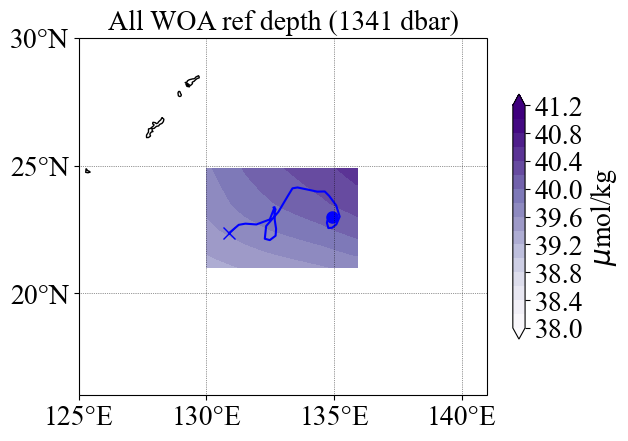

In [15]:
draw_var = ref_dep_lerpdata[best_depth]

vmin = 38
vmax = 41
vint = 0.2

fig = plt.figure()
rcParams['figure.figsize'] = 8,6
c_lon = 180
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree(central_longitude=c_lon))


cm = plt.get_cmap('Purples') 
cs = ax.contourf(new_lon, new_lat, draw_var, cmap=cm, norm=Normalize(vmin=vmin, vmax=vmax),\
                  levels=np.arange(vmin,vmax+vint,vint), extend='both', \
                  transform=ccrs.PlateCarree())
linecs = ax.contour(new_lon-180, new_lat, draw_var, colors='k',levels=np.arange(0,5,1), linewidths=1) #等値線
ax.clabel(linecs, fontsize=15, inline=True, inline_spacing=0.2, use_clabeltext=True)

ax.plot(lon_array[:, 0],lat_array[:, 0], color = 'b', lw = '1.5', transform=ccrs.PlateCarree())

ax.plot(lon_array[0],lat_array[0], 'ob', markersize = '8', label = 'start', transform=ccrs.PlateCarree())
ax.plot(lon_array[-1],lat_array[-1], 'xb', markersize = '8', label = 'end', transform=ccrs.PlateCarree())


dlon,dlat=5,5
xticks=np.arange(60,360.1,dlon)
yticks=np.arange(-60,70.1,dlat)
ax.set_title('All WOA ref depth (1341 dbar)', fontsize=20)
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())
ax.coastlines(lw=1.0,color='black',resolution='50m')
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
ax.axes.tick_params(labelsize=20)
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, linestyle=':', color='k', alpha=0.8)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
cbar = plt.colorbar(cs, shrink=0.6) 
cbar.ax.tick_params(labelsize=20)
cbar.set_label(r"$\mu$mol/kg", size=20) 

ax.set_extent([w-5, e+5, s-5, n+5], crs=ccrs.PlateCarree())

plt.tight_layout()

### フロートの位置に最も近い new_lon, new_lat のインデックスを探す

In [16]:
nearest_lon_idx = np.array([np.abs(new_lon - lon).argmin() for lon in lon_array.flatten()])
nearest_lat_idx = np.array([np.abs(new_lat - lat).argmin() for lat in lat_array.flatten()])

# interpolated_data から最も近い格子点の時系列データを取得
# (深さ 5500 のデータを時系列で取得)
woa_time_series = np.array([
    ref_dep_lerpdata[:, nearest_lat_idx[i], nearest_lon_idx[i]] for i in range(len(lon_array))
])

# 結果の形状確認
print(woa_time_series.shape)  # (時系列の長さ, 5500)

(33, 5500)


### Drawing the timeseries of the profiles

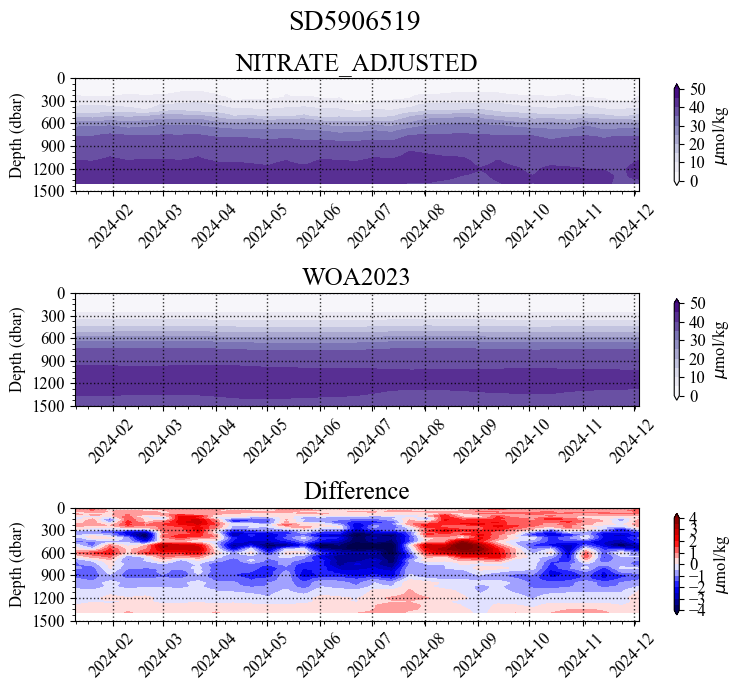

In [17]:
draw_var2 = lerp_adjusted_qc.transpose(1, 0)
draw_var1 = woa_time_series.transpose(1, 0)
draw_var3 = (lerp_adjusted_qc-woa_time_series[:, :min_depth]).transpose(1, 0)
    
vmin = 0
vmax = 50
vint = 5
    
cm = plt.get_cmap('Purples') 
    
rcParams['figure.figsize'] = 8,7
fig = plt.figure()
fig.suptitle(f"{fnum}", fontsize=20, x=0.45)

ax2 = fig.add_subplot(3,1,1)
cs = plt.contourf(time_list, depth_lerp, draw_var2, 
                  cmap=cm, norm=Normalize(vmin=vmin, vmax=vmax),
                  levels=np.arange(vmin,vmax+vint,vint), extend='both')

ax2.set_title(f"{var2}", fontsize=18)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))
ax2.tick_params(axis='x', rotation=45)  # 日付ラベルを45度傾けて見やすくする
ax2.set_yticks(np.linspace(0, 1500, num=6))
ax2.axes.tick_params(labelsize=12)
#ax2.set_yticklabels(["200","150","100","50","0"])
ax2.set_ylabel("Depth (dbar)", size=12)
ax2.grid(linewidth=1, linestyle=':', color='k', alpha=0.8)
ax2.invert_yaxis()  # 深度を下向きにする
ax2.minorticks_on()
ax2.set_ylim(1500, 0)
    
cbar = plt.colorbar(cs, shrink=0.9) 
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r"$\mu$mol/kg", size=12)

ax1 = fig.add_subplot(3,1,2)
cs = plt.contourf(time_list, new_dep, draw_var1, 
                  cmap=cm, norm=Normalize(vmin=vmin, vmax=vmax),
                  levels=np.arange(vmin,vmax+vint,vint), extend='both')

ax1.set_title("WOA2023", fontsize=18)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))
ax1.tick_params(axis='x', rotation=45)  # 日付ラベルを45度傾けて見やすくする
ax1.set_yticks(np.linspace(0, 1500, num=6))
ax1.axes.tick_params(labelsize=12)
#ax1.set_yticklabels(["200","150","100","50","0"])
ax1.set_ylabel("Depth (dbar)", size=12)
ax1.grid(linewidth=1, linestyle=':', color='k', alpha=0.8)
ax1.invert_yaxis()  # 深度を下向きにする
ax1.minorticks_on()
ax1.set_ylim(1500, 0)
    
cbar = plt.colorbar(cs, shrink=0.9) 
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r"$\mu$mol/kg", size=12)

ax3 = fig.add_subplot(3,1,3)

vmin = -4
vmax = 4
vint = 0.5

cs = plt.contourf(time_list, depth_lerp, draw_var3, 
                  cmap=plt.get_cmap('seismic'), norm=Normalize(vmin=vmin, vmax=vmax),
                  levels=np.arange(vmin,vmax+vint,vint), extend='both')

ax3.set_title("Difference", fontsize=18)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))
ax3.tick_params(axis='x', rotation=45)  # 日付ラベルを45度傾けて見やすくする
ax3.set_yticks(np.linspace(0, 1500, num=6))
ax3.axes.tick_params(labelsize=12)
#ax3.set_yticklabels(["200","150","100","50","0"])
ax3.set_ylabel("Depth (dbar)", size=12)
ax3.grid(linewidth=1, linestyle=':', color='k', alpha=0.8)
ax3.minorticks_on()
ax3.invert_yaxis()  # 深度を下向きにする
ax3.set_ylim(1500, 0)
    
cbar = plt.colorbar(cs, shrink=0.9) 
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r"$\mu$mol/kg", size=12)

plt.tight_layout()

## Calculate the difference between the float data and WOA data

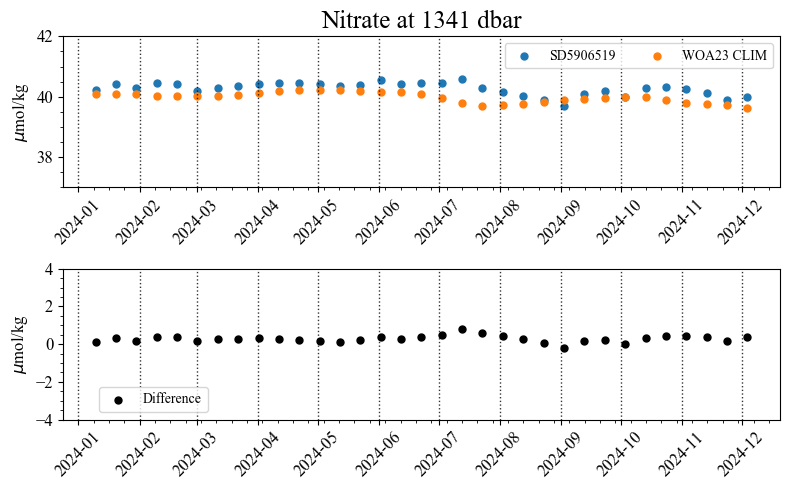

In [18]:
rcParams['figure.figsize'] = 8,5
fig = plt.figure()
ax = fig.add_subplot(2,1,1)

#ax1.scatter(x, diff_Data, color="green", edgecolor="black", zorder=2)
ax.scatter(time_list, lerp_adjusted_qc[:, best_depth], s= 25, label = f"{fnum}")
ax.scatter(time_list, woa_time_series[:, best_depth], s= 25, label = 'WOA23 CLIM')
ax.set_title(f"Nitrate at {best_depth} dbar", fontsize=18)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))
ax.tick_params(axis='x', rotation=45)  # 日付ラベルを45度傾けて見やすくする
#yticks = np.arange(-0.02, 0.021, 0.01)
#ax.set_yticks(yticks)
ax.axes.tick_params(labelsize=12)
#ax3.set_yticklabels(["200","150","100","50","0"])]
ax.legend(fontsize=10, ncol=3)
ax.set_ylabel((r"$\mu$mol/kg"), size=12)
ax.grid(axis = 'x', linewidth=1, linestyle=':', color='k', alpha=0.8)
ax.minorticks_on()
ax.set_ylim(37, 42)

ax = fig.add_subplot(2,1,2)

ax.scatter(time_list, lerp_adjusted_qc[:, best_depth]-woa_time_series[:, best_depth], s= 25, c = 'k', label = "Difference")
#ax.plot(time_list, woa_time_series, label = 'WOA23 CLIM')
#ax.set_title(f"Diff at {fnum} {best_depth} dbar", fontsize=18)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))
ax.tick_params(axis='x', rotation=45)  # 日付ラベルを45度傾けて見やすくする
#yticks = np.arange(-0.02, 0.021, 0.01)
#ax.set_yticks(yticks)
ax.axes.tick_params(labelsize=12)
#ax3.set_yticklabels(["200","150","100","50","0"])]
ax.legend(loc= (0.05, 0.05), fontsize=10, ncol=3)
ax.set_ylabel((r"$\mu$mol/kg"), size=12)
ax.grid(axis = 'x', linewidth=1, linestyle=':', color='k', alpha=0.8)
ax.minorticks_on()
ax.set_ylim(-4, 4)

plt.tight_layout()

### Define the break points

In [19]:
diff_Data = lerp_adjusted_qc[:, best_depth]-woa_time_series[:, best_depth]

# **データの準備**
n_cycles = diff_Data.shape[0]
x = np.arange(n_cycles)  # cycle のインデックス

# **Binary segmentation 実行**
algo = rpt.Binseg(model="l2", min_size=max(1, n_cycles//10)).fit(diff_Data)
possible_bkps = algo.predict(n_bkps=(n_cycles//10) -1)  # セグメント数 = (n数/10)の整数部分 -1 

# **ブレークポイントの前処理**
if isinstance(possible_bkps, int):  
    possible_bkps = [0, possible_bkps, n_cycles]
elif not isinstance(possible_bkps, list):  
    raise ValueError("Breakpoints should be a list, but got:", possible_bkps)

if possible_bkps[0] != 0:
    possible_bkps.insert(0, 0)
if possible_bkps[-1] != n_cycles:
    possible_bkps.append(n_cycles)

### Defeine the Drifts

Detected breakpoints: 2024-01-09 18:39:02.001988
Detected breakpoints: 2024-06-12 00:05:37.000007
Detected breakpoints: 2024-08-02 09:50:07.001038
Adjusted difference mean =  0.2975942908635983


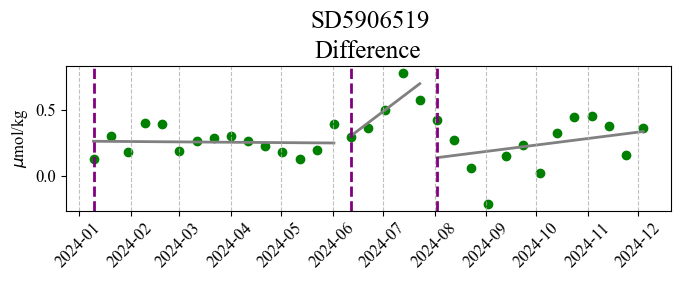

In [20]:
# **X軸をdatetimeのまま保持し、回帰には数値を使う**
x = np.array(time_list)  
x_numeric = mdates.date2num(x)  # datetime を float に変換

# **グラフの設定**
rcParams['figure.figsize'] = 7,3
fig = plt.figure()
fig.suptitle(f"{fnum}", fontsize=18, x=0.55, y=0.92)

ax1 = fig.add_subplot(1,1,1)
ax1.set_title("Difference", fontsize=18)
ax1.scatter(x, diff_Data, color="g")
ax1.set_ylabel(r"$\mu$mol/kg", size=12)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # 1ヶ月ごとにラベルを表示
ax1.axes.tick_params(labelsize=12)
ax1.tick_params(axis='x', rotation=45)  # 日付ラベルを45度傾けて見やすくする
ax1.grid(axis = 'x', linestyle="--", alpha=0.8)

# **各セグメントで最小二乗法を適用**
drift = []
prev_bkp = 0

for bkp in possible_bkps[1:]:
    x_segment = x_numeric[prev_bkp:bkp]  # **回帰用に float を使う**
    y_segment = diff_Data[prev_bkp:bkp]

    # **線形回帰（datetime ではなく float を使う）**
    model = LinearRegression().fit(x_segment.reshape(-1, 1), y_segment)
    y_pred = model.predict(x_segment.reshape(-1, 1))

    # **プロット用に元の datetime に戻す**
    ax1.plot(x[prev_bkp:bkp], y_pred, color="gray", linewidth=2, zorder=1)

    # **セグメント開始点に破線を追加**
    ax1.axvline(x[prev_bkp], color="purple", linestyle="dashed", linewidth=2)
    prev_bkp = bkp
    drift.append(y_pred)

model_diff = np.concatenate(drift)
modify_adjustedData = lerp_adjusted_qc-model_diff[:, np.newaxis]

# **ブレークポイントの出力**
for i in range(len(possible_bkps)-1):  
    print("Detected breakpoints:", time_list[possible_bkps[i]])
    
print("Adjusted difference mean = ", np.mean(np.abs(diff_Data)))

plt.tight_layout()

### subtracte the difference from the float data

In [21]:
diff_modiData = modify_adjustedData[:, best_depth]-woa_time_series[:, best_depth]

Corrected difference =  0.1009453136077863


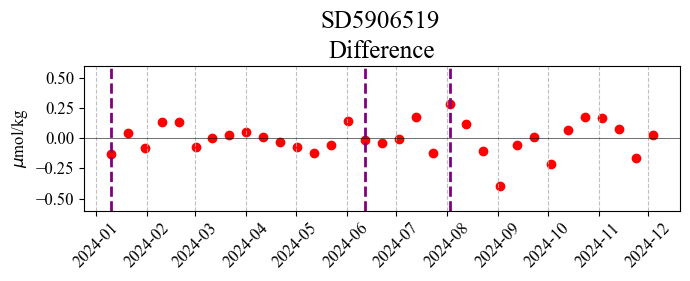

In [22]:
# **X軸をdatetimeのまま保持し、回帰には数値を使う**
x = np.array(time_list)  
x_numeric = mdates.date2num(x)  # datetime を float に変換

# **グラフの設定**
rcParams['figure.figsize'] = 7,3
fig = plt.figure()
fig.suptitle(f"{fnum}", fontsize=18, x=0.55, y=0.92)

ax1 = fig.add_subplot(1,1,1)
ax1.set_title("Difference", fontsize=18)
ax1.scatter(x, diff_modiData, color="r")
ax1.set_ylabel(r"$\mu$mol/kg", size=12)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # 1ヶ月ごとにラベルを表示
ax1.axes.tick_params(labelsize=12)
ax1.tick_params(axis='x', rotation=45)  # 日付ラベルを45度傾けて見やすくする
yticks=np.arange(-0.5, 0.51, 0.25)
ax1.set_yticks(yticks)
ax1.grid(axis = 'x', linestyle="--", alpha=0.8)
ax1.set_ylim(-0.6, 0.6)
ax1.hlines(y=0.5, xmin=0, xmax=1, lw = 0.5, color='k', alpha=0.8, transform=ax1.transAxes)

print("Corrected difference = ", np.mean(np.abs(diff_modiData)))

# **各セグメントで最小二乗法を適用**
drift = []
prev_bkp = 0

for bkp in possible_bkps[1:]:
    x_segment = x_numeric[prev_bkp:bkp]  # **回帰用に float を使う**
    y_segment = diff_Data[prev_bkp:bkp]

    # **線形回帰（datetime ではなく float を使う）**
    model = LinearRegression().fit(x_segment.reshape(-1, 1), y_segment)
    y_pred = model.predict(x_segment.reshape(-1, 1))

    # **セグメント開始点に破線を追加**
    ax1.axvline(x[prev_bkp], color="purple", linestyle="dashed", linewidth=2)
    prev_bkp = bkp

plt.tight_layout()

### Drawing the timeseries of the corrected profiles

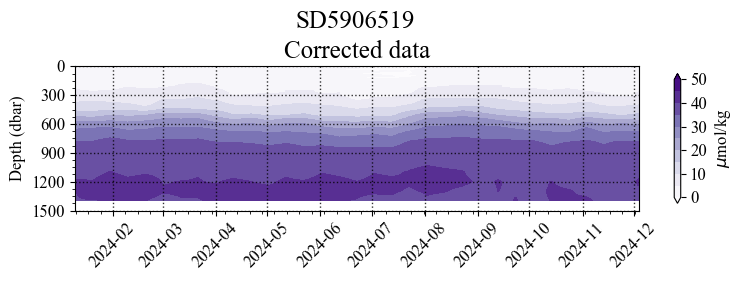

In [23]:
draw_var = modify_adjustedData.transpose(1, 0)
    
vmin = 0
vmax = 50
vint = 5
    
cm = plt.get_cmap('Purples') 
    
rcParams['figure.figsize'] = 8,3
fig = plt.figure()
fig.suptitle(f"{fnum}", fontsize=18, x=0.45, y=0.92)

ax = fig.add_subplot(1,1,1)
cs = plt.contourf(time_list, depth_lerp, draw_var, 
                  cmap=cm, norm=Normalize(vmin=vmin, vmax=vmax),
                  levels=np.arange(vmin,vmax+vint,vint), extend='both')

ax.set_title("Corrected data", fontsize=18)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))
ax.tick_params(axis='x', rotation=45)  # 日付ラベルを45度傾けて見やすくする
ax.set_yticks(np.linspace(0, 1500, num=6))
ax.axes.tick_params(labelsize=12)
ax.set_ylabel("Depth (dbar)", size=12)
ax.grid(linewidth=1, linestyle=':', color='k', alpha=0.8)
ax.invert_yaxis()  # 深度を下向きにする
ax.minorticks_on()
ax.set_ylim(1500, 0)
    
cbar = plt.colorbar(cs, shrink=0.9) 
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r"$\mu$mol/kg", size=12)

plt.tight_layout()

In [24]:
modify_adjustedData.shape

(33, 1399)